# Evaluation Reaction diffusion

In [1]:
import os
import yaml
import json

import torch

from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np

from src.nnets.utils import load_model
from src.data_loader.data_loader import get_data_loader
from src.data_loader.config_data_loader import SimulatorDataset
from src.forward_models.init_physics_model import init_physics_solver_model
from src.metrics.mmd import MMDLoss, RBF, estimate_mmd_bandwidth


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(13)
np.random.seed(13)
task_name = "reactdiff"
test_exp_name = "5c90bf1a6dd3956b1aac2e6ab52fe076"
dataset_file_path = f"../../../datasets/forward_models/reactdiff/testing/data_{test_exp_name}.pt"

test_dataset = SimulatorDataset(
    name_dataset=task_name,
    data_file_path=dataset_file_path,
    testing_set=True,
    device=device,
)
test_loader = get_data_loader(
    test_dataset, batch_size=512
)  # batch size can be adjusted


In [3]:
# Load the model
params_dim = 2

path_model_file = f"../../../outputs/best_models/reactdiff/one-to-one/ot-gb/nrmse/6d7ca3fe37f2ac0950134a4dc31a7b48/2U9m_score_0.0339_epoch_-1/model_77bd6b062f3633311559a1d64926d80b_exp_61a0a9280e623987eeee47cb59a4d60a_6d7ca3fe37f2ac0950134a4dc31a7b48_salt_2U9m_best.pt"
ot_gb_model, parent_dir, config, _ = load_model(
    path_model_file=path_model_file,
    params_dim=params_dim,
)
path_model_file = f"../../../outputs/best_models/reactdiff/one-to-one/wgans-gb/nrmse/61a0a9280e623987eeee47cb59a4d60a/pkJ8_score_0.0203_epoch_-1/model_f1c8df0766f00833251f7433c51ab03f_exp_61a0a9280e623987eeee47cb59a4d60a_6d7ca3fe37f2ac0950134a4dc31a7b48_salt_pkJ8_best.pt"
wgans_gb_model, parent_dir, config, _ = load_model(
    path_model_file=path_model_file,
    params_dim=params_dim,
)

# WGANS - BB 
path_model_file = f"../../../outputs/best_models/reactdiff/one-to-one/wgans-bb/nrmse/61a0a9280e623987eeee47cb59a4d60a/1Naa_score_0.1023_epoch_-1/model_9dfbd7aab0ca686d8c3a5c5bff6dc3cc_exp_61a0a9280e623987eeee47cb59a4d60a_6d7ca3fe37f2ac0950134a4dc31a7b48_salt_1Naa_final.pt"
wgans_bb_model, parent_dir, config, _ = load_model(
    path_model_file=path_model_file,
    params_dim=params_dim,
)

Loading model from ../../../outputs/best_models/reactdiff/one-to-one/ot-gb/nrmse/6d7ca3fe37f2ac0950134a4dc31a7b48/2U9m_score_0.0339_epoch_-1/model_77bd6b062f3633311559a1d64926d80b_exp_61a0a9280e623987eeee47cb59a4d60a_6d7ca3fe37f2ac0950134a4dc31a7b48_salt_2U9m_config.yaml
NeuralReactDiff(
  (react_diff_model): ReactDiffDynamics()
  (nnet): ReactDiffNNet(
    (conv_input): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (h_blocks): ModuleList(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (output_layer): Conv2d(16, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (context_blocks): ModuleList(
      (0-1): 2 x Linear(in_features=2, out_features=1024, bias=True)
    )
  )
)
Loading model from ../../../outputs/best_models/reactdiff/one-to-one/ot-gb/nrmse/6d7ca3fe37f2ac0950134a4dc31a7b48/2U9m_score_0.0339_epoch_-1/model_77bd6b062f3633311559a1d64926d80b_exp_61a0a9280e623987eeee47cb59a4d60a_6d7ca3fe37f2ac0950134a4dc31a7b48_

In [4]:
test_samples = test_loader.sample()
test_params = test_samples["params"]
test_sims = test_samples["x"]
print(test_params.shape, test_sims.shape)
test_init_conds = test_samples["init_conds"]
print(test_params.shape)
print(test_init_conds.shape)
print(test_sims.shape)


torch.Size([200, 1, 3]) torch.Size([200, 1, 2, 32, 32, 16])
torch.Size([200, 1, 3])
torch.Size([200, 1, 2, 32, 32])
torch.Size([200, 1, 2, 32, 32, 16])


In [5]:
print(test_params.shape)
print(test_init_conds.shape)
print(test_sims.shape)


torch.Size([200, 1, 3])
torch.Size([200, 1, 2, 32, 32])
torch.Size([200, 1, 2, 32, 32, 16])


In [6]:
X_params = test_params[:,:, :params_dim].squeeze(1)
X_init_conds = test_init_conds.squeeze(1)
phys_solver = init_physics_solver_model(config=config, device=device)
res_sims = phys_solver(init_conds=X_init_conds, params=X_params)
X_sims = res_sims["x"]
# Print shapes
print(X_params.shape)
print(X_init_conds.shape)
print(X_sims.shape)

torch.Size([200, 2])
torch.Size([200, 2, 32, 32])
torch.Size([200, 2, 32, 32, 16])


In [7]:
# Stack the time dimension
def vis_diffusion(axes,U, U_true=None, time_eval=None):
    if U_true is not None:
        diff = np.abs(U - U_true)
    if time_eval is None:
        U_evolution = np.concatenate([U[:,:,t] for t in range(U.shape[2])], axis=1)
        if U_true is not None:
            diff_evol = np.concatenate([diff[:,:,t] for t in range(U.shape[2])], axis=1)
    else:
        U_evolution = np.concatenate([U[:,:,t] for t in time_eval], axis=1)
        if U_true is not None:
            diff_evol = np.concatenate([diff[:,:,t] for t in time_eval], axis=1)
    print(U_evolution.shape)
    if U_true is not None:
        fig, axes = plt.subplots(2, 1, figsize=(12, 4))
        pos = axes[0].imshow(U_evolution, cmap="magma", interpolation='spline16')
        axes[0].set_title('Reaction Diffusion')
        axes[0].set_xlabel('t')
        axes[0].set_ylabel('U')
        axes[0].set_title('Reaction Diffusion')
        fig.colorbar(pos, ax=axes[0], location='right')
        
        pos = axes[1].imshow(diff_evol, cmap="magma", interpolation='spline16')
        axes[1].set_title('Absolute Error')
        axes[1].set_xlabel('t')
        axes[1].set_ylabel(r'$\Delta U$')
        fig.colorbar(pos, ax=axes[1], location='right',)
        
    else:
        plt.imshow(U_evolution, cmap="magma", interpolation='spline16')
        plt.xlabel('t')
        plt.ylabel('U')
        plt.colorbar()
        plt.title('Reaction Diffusion')
    plt.tight_layout()


In [8]:
pred_wgan = wgans_gb_model.predict(X_sims, context=X_params)
pred_ot = ot_gb_model.predict(X_sims, context=X_params)
pred_bb = wgans_bb_model.predict(X_sims, context=X_params)
pred_wgan.shape, X_sims.shape, test_sims.shape


(torch.Size([200, 2, 32, 32, 16]),
 torch.Size([200, 2, 32, 32, 16]),
 torch.Size([200, 1, 2, 32, 32, 16]))

In [9]:
rnd_sample = np.random.randint(0, test_sims.shape[0])

176


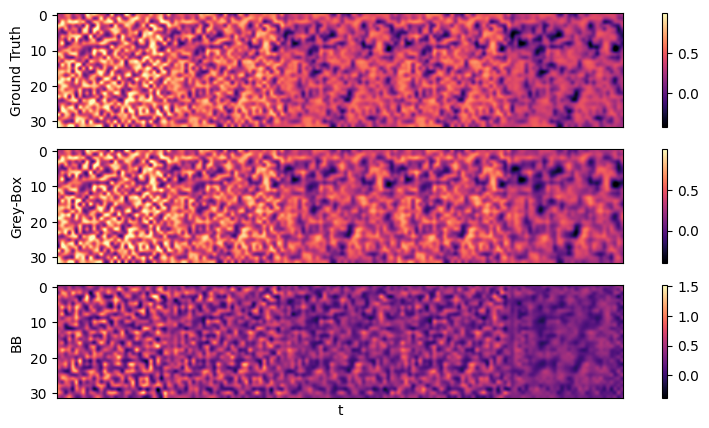

In [10]:
# random sample
rnd_sample = np.random.randint(0, test_sims.shape[0])
print(rnd_sample)
p_ot = pred_ot[rnd_sample]
p_wgan = pred_wgan[rnd_sample]
p_bb = pred_bb[rnd_sample]
Y = test_sims[rnd_sample][0]

# plot
U_hat_wgan = p_wgan[0].detach().cpu().numpy()
U_hat_ot = p_ot[0].detach().cpu().numpy()
U_hat_bb = p_bb[0].detach().cpu().numpy()
U_Y = Y[0].detach().cpu().numpy()
#fig, axes = plt.subplots(1, 4, figsize=(14, 7), sharey=True)
maximum = 0
t_evals = [0, 4, 10, 8, 15]
U_hat_ev = np.concatenate([U_hat_wgan[:,:,t] for t in t_evals], axis=1)
U_ev = np.concatenate([U_Y[:,:,t] for t in t_evals], axis=1)

fig, axes = plt.subplots(3, 1, figsize=(10, 5), sharex=True)

pos = axes[0].imshow(U_ev, cmap="magma", interpolation='spline16')
axes[1].set_xticks([])
axes[0].set_xlabel(None)
axes[0].set_ylabel(f'Ground Truth')
fig.colorbar(pos, ax=axes[0], location='right',)

pos = axes[1].imshow(U_hat_ev, cmap="magma", interpolation='spline16')
axes[1].set_xlabel(None)
axes[1].set_ylabel(f'Grey-Box')
axes[1].set_xticks([])
fig.colorbar(pos, ax=axes[1], location='right')

U_bb_ev = np.concatenate([U_hat_bb[:,:,t] for t in t_evals], axis=1)
pos = axes[2].imshow(U_bb_ev, cmap="magma", interpolation='spline16')
axes[2].set_xlabel('t')
axes[2].set_ylabel('BB')
axes[2].set_xticks([])
fig.colorbar(pos, ax=axes[2], location='right')

plt.margins(0,0)
plt.savefig(f"./react_diff.png", bbox_inches = 'tight')
plt.show()
    